##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



# Load images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial provides a simple example of how to load an image dataset using `tf.data`.

The dataset used in this example is distributed as directories of images, with one class of image per directory.

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib, os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
tf.__version__

'2.1.0'

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [7]:
data_dir = pathlib.Path('inv/train_small')


image_count = len(list(data_dir.glob('*/*.jpeg')))

print(f'The image count is {image_count}')




The image count is 3111


In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
epochs = 15

STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "submission.csv"])
len(CLASS_NAMES)

137

b'inv/train_small/Neptuneopsis_gilchristi/Y1WDFML.jpeg'
b'inv/train_small/Philinopsis_capensis/45DJ4EI.jpeg'
b'inv/train_small/Inachidae/X0NA3SH.jpeg'
b'inv/train_small/Comitas_saldanhae/1ABW0MS.jpeg'
b'inv/train_small/Ophiura_trimeni/ZIXY0DH.jpeg'


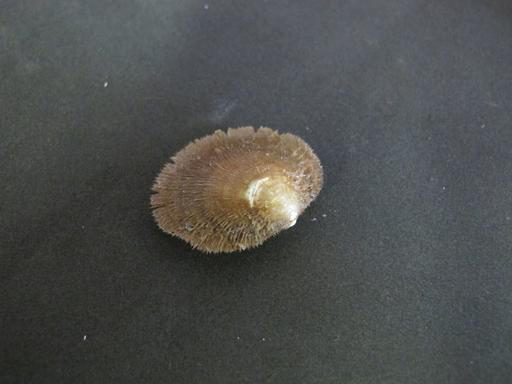

In [9]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

lim = list(data_dir.glob('Limopsis_chuni/*'))

for image_path in lim[:1]:
    display.display(Image.open(str(image_path)))


Each directory contains images of that type of flower. Here are some roses:

In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Use Dataset.map to create a dataset of image, label pairs:

In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [12]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

Let's compare the speed of the two data generators:

A large part of the performance gain comes from the use of `.cache`.

In [13]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(14,14))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


In [15]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))


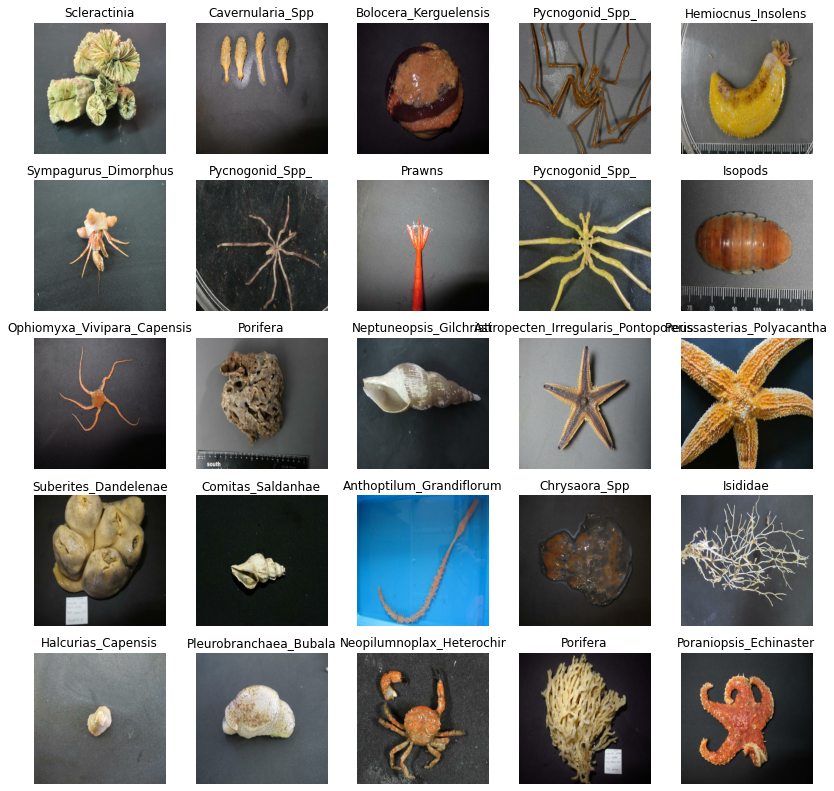

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())


### Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a relu activation function.

In [17]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(137)
])


### Compile the model

For this tutorial, choose the ADAM optimizer and binary cross entropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Model summary

View all the layers of the network using the model's summary method:

In [19]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [20]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
e_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch= STEPS_PER_EPOCH,
    epochs=epochs,
    callbacks= [save_callback,
               e_stop_callback]
)

Train for 98.0 steps
Epoch 1/15
97/98 [============================>.] - ETA: 4s - loss: 0.0611 - accuracy: 0.9924
Epoch 00001: saving model to training_1/cp.ckpt
98/98 [==============================] - 467s 5s/step - loss: 0.0609 - accuracy: 0.9924
Epoch 2/15
97/98 [============================>.] - ETA: 2s - loss: 0.0400 - accuracy: 0.9927
Epoch 00002: saving model to training_1/cp.ckpt
98/98 [==============================] - 236s 2s/step - loss: 0.0399 - accuracy: 0.9927
Epoch 3/15
97/98 [============================>.] - ETA: 3s - loss: 0.0328 - accuracy: 0.9929
Epoch 00003: saving model to training_1/cp.ckpt
98/98 [==============================] - 330s 3s/step - loss: 0.0327 - accuracy: 0.9929
Epoch 4/15
97/98 [============================>.] - ETA: 2s - loss: 0.0238 - accuracy: 0.9938
Epoch 00004: saving model to training_1/cp.ckpt
98/98 [==============================] - 254s 3s/step - loss: 0.0238 - accuracy: 0.9938
Epoch 5/15
97/98 [============================>.] - ETA: 2s